# Fitting Overtones in GW150914

_NOTE:_ this example is inteneded to demonstrate the functionality of the `ringdown` package using GW150914 as an example; it is not meant to reproduce the result from [Isi, et al. (2019)](https://ui.adsabs.harvard.edu/abs/2019PhRvL.123k1102I/abstract): we use a more general polarization model, assume different priors, and apply slightly different data conditioning; therefore, the results should not be expected to be identical Isi et al (2019).

This first cell must be executed first in order for Stan's multiprocessing code to not crash some MacOS setups; on linux it's not needed.

In [1]:
import multiprocessing
multiprocessing.set_start_method("fork")

In [2]:
%pylab inline
%config InlineBackend.figure_format = 'retina'

Populating the interactive namespace from numpy and matplotlib


In [3]:
import arviz as az
import copy 
import h5py
import gwtones
import pandas as pd
import seaborn as sns

sns.set_context('notebook')
sns.set_palette('colorblind')

## Data

Let's download the data for GW150914, found [here](https://www.gw-openscience.org/eventapi/html/GWTC-1-confident/GW150914/v3/).  We grab 32s of data in each IFO, sampled at 16 kHz.

In [4]:
#!wget https://www.gw-openscience.org/eventapi/html/GWTC-1-confident/GW150914/v3/H-H1_GWOSC_16KHZ_R1-1126259447-32.hdf5
#!wget https://www.gw-openscience.org/eventapi/html/GWTC-1-confident/GW150914/v3/L-L1_GWOSC_16KHZ_R1-1126259447-32.hdf5

If you grab the data, the MD5 sums should be:
```
MD5(H-H1_GWOSC_16KHZ_R1-1126259447-32.hdf5)= b345645c0488287301824fe617f58dc2
MD5(L-L1_GWOSC_16KHZ_R1-1126259447-32.hdf5)= 5eb246ff21364d38471c95452f012853
```

In [5]:
!openssl md5 H-H1_GWOSC_16KHZ_R1-1126259447-32.hdf5
!openssl md5 L-L1_GWOSC_16KHZ_R1-1126259447-32.hdf5

MD5(H-H1_GWOSC_16KHZ_R1-1126259447-32.hdf5)= b345645c0488287301824fe617f58dc2
MD5(L-L1_GWOSC_16KHZ_R1-1126259447-32.hdf5)= 5eb246ff21364d38471c95452f012853


Now we make timeseries data objects out of the stored data:

In [6]:
def read_strain(file, dname):
    with h5py.File(file, 'r') as f:
        t0 = f['meta/GPSstart'][()]
        T = f['meta/Duration'][()]
        h = f['strain/Strain'][:]
    
        dt = T/len(h)
    
        raw_strain = gwtones.Data(h, index=t0 + dt*arange(len(h)), ifo=dname)
        
        return raw_strain
    
h_raw_strain = read_strain('H-H1_GWOSC_16KHZ_R1-1126259447-32.hdf5', 'H1')
l_raw_strain = read_strain('L-L1_GWOSC_16KHZ_R1-1126259447-32.hdf5', 'L1')

Just a sanity-check plot of the raw strain (just look at the huuuuuge DC noise in LIGO):

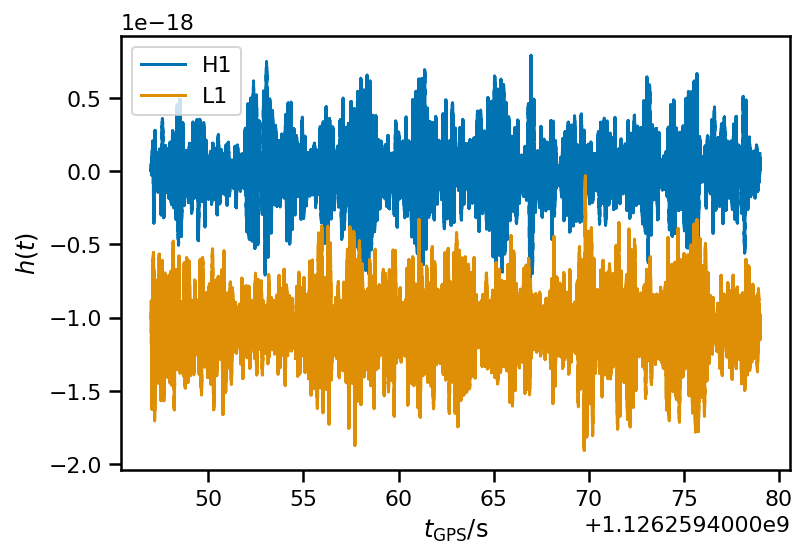

In [7]:
h_raw_strain.plot(label=h_raw_strain.ifo)
l_raw_strain.plot(label=l_raw_strain.ifo)
xlabel(r'$t_\mathrm{GPS} / \mathrm{s}$')
ylabel(r'$h(t)$')
legend(loc='best')

Now that we've got the strain loaded up, we want to condition it a bit.  LIGO does not have very good high-frequency sensitivity; also, our modes do not have a lot of high-frequency content.  Additionally, LIGO contains a lot of low-frequency noise and our templates do not have a lot of power at low frequencies.  Here are estimated noise PSDs for our data:

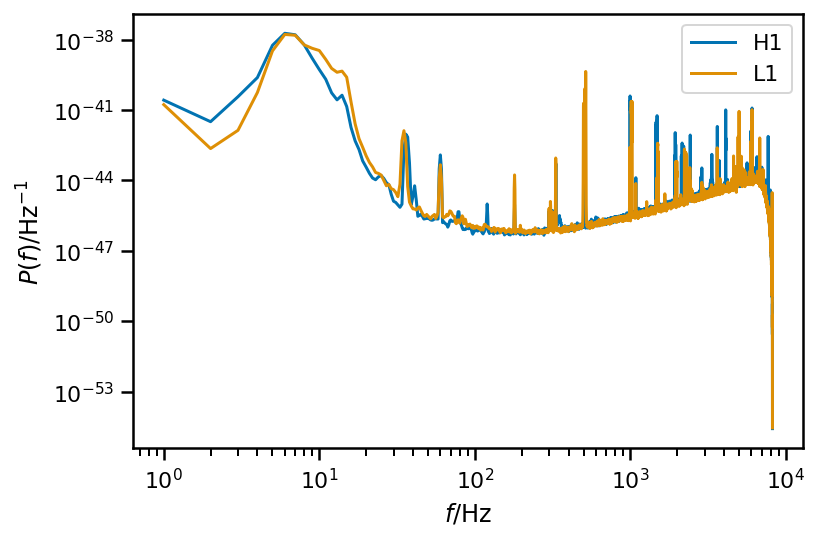

In [8]:
h_raw_strain.get_psd(nperseg=int(h_raw_strain.fsamp)).iloc[1:].plot(label=h_raw_strain.ifo)
l_raw_strain.get_psd(nperseg=int(l_raw_strain.fsamp)).iloc[1:].plot(label=l_raw_strain.ifo)
xlabel(r'$f / \mathrm{Hz}$')
ylabel(r'$P\left( f \right) / \mathrm{Hz}^{-1}$')
xscale('log')
yscale('log')
legend(loc='best')

Because the cost of our analysis scales as $N^2$ for a data segment of $N$ samples, and because the noise in LIGO combined with the finite bandwidth of ringdown modes means that the data are uninformative at both very low and very high frequencies, we can bandpass the data, downsample considerably (to eliminate high-frequency content), and truncate to a very short data segment (to eliminate low frequency content).  The `condition_data` method below accomplishes this; anticipating that we will only be analyzing the first two tones of the $(p = 1, s = -2, \ell = 2, m = 2)$ series of modes (prograde, spin-weight 2, angular quantum numbers $(2,2)$ modes), we will downsample to a sample rate of 4096 Hz, and a segment length of $\sim 40\, \mathrm{ms}$.  This is adequate to capture both the decay rate of the second tone (~700 Hz), and also the length of the first tone (time constant ~ 4.3 ms).  Generally, sampling at 2 to 4 times the decay rate of the highest overtone is sufficient to capture its decay smoothly (see plot below); above 1 or 2 kHz there is also so much noise in the LIGO interferometers that there is very little chance to measure anything at these frequencies.

You can see below that we choose a segment length that is ten times the estimated decay rate of the fundamental mode and a sampling frequency that is at least 4 times the decay rate of the first (highest) overtone.  These are conservative choices for most analyses.

Text(0, 0.5, '$\\exp\\left( - t / \\tau \\right)$')

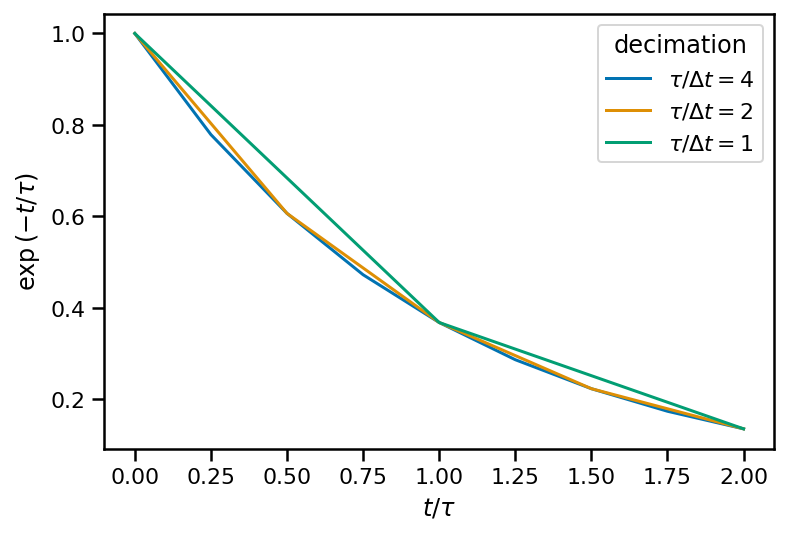

In [9]:
x = linspace(0, 2, 9)
for i in [1, 2, 4]:
    plot(x[::i], exp(-x[::i]), label=r'$\tau / \Delta t = {:.0f}$'.format(4/i))
legend(title='decimation')
xlabel(r'$t / \tau$')
ylabel(r'$\exp\left( - t / \tau \right)$')

In [10]:
M_est = 70.0
chi_est = 0.7

longest_tau = gwtones.qnms.get_ftau(M_est, chi_est, 0, l=2, m=2)[1]
highest_drate = 1/gwtones.qnms.get_ftau(M_est, chi_est, 1, l=2, m=2)[1]
print('The damping rate of the second tone is: {:.1f} Hz'.format(highest_drate))
print('The time constant of the first tone is: {:.1f} ms'.format(1000*longest_tau))

def next_pow_two(x):
    y = 1
    while y < x:
        y = y << 1
    return y

T = 10*longest_tau
srate = next_pow_two(4*highest_drate)

print('Segment of {:.1f} ms at sample rate {:.0f}'.format(1000*T, srate))

The damping rate of the second tone is: 708.4 Hz
The time constant of the first tone is: 4.3 ms
Segment of 42.7 ms at sample rate 4096


When we downsample, we want to be sure to preserve a sample as close as possible to the ringdown "start time," corresponding to the arrival time of the peak of the complex strain of the (2,2) mode ([Giesler, et al. 2019](https://ui.adsabs.harvard.edu/abs/2019PhRvX...9d1060G/abstract)).  One issue we have to deal with is that the signal arrives in the detectors at different times (the time delay between detectors depends on the source location on the sky).  The `Fit` object knows how to handle this for us.  We take the sky location, polarization, and time of arrival from [Isi, et al. (2019)](https://ui.adsabs.harvard.edu/abs/2019PhRvL.123k1102I/abstract), set the desired duration and sample rate, and call `condition_data`.  We high-pass filter the data with rollon at $20 \, \mathrm{Hz}$ to eliminate the large low-frequency noise present in the data.

The fit object expects to receive a list of modes to include in the fit; the most explicit way to specify them is to give tuples of `(p, s, l, m, n)`, where `p = +/- 1` indicates prograde/retrograde, `s = -2` is the spin weight, `l` and `m` are the usual angular quantum numbers, and `n` is the tone index.  (The modes are elliptically polarized, so there is no need to specify both + and - `m` quantum numbers; it is assumed that both positive and negative `m` contribute to a mode.)  Because Isi, et al. (2019) found only convincing evidence of two tones, that is the model we fit in this example.

In [11]:
fit = gwtones.Fit(model='mchi', modes=[(1, -2, 2, 2, 0), (1, -2, 2, 2, 1)])  # use model='ftau' to fit damped sinusoids instead of +/x polarized GW modes
fit.add_data(h_raw_strain)
fit.add_data(l_raw_strain)
fit.set_target(1126259462.4083147, ra=1.95, dec=-1.27, psi=0.82, duration=T)
fit.condition_data(ds=int(round(h_raw_strain.fsamp/srate)), flow=20)

It is instructive to look at the whitened data segment in both interferometers:

Text(0, 0.5, 'Whitened Analysis Data')

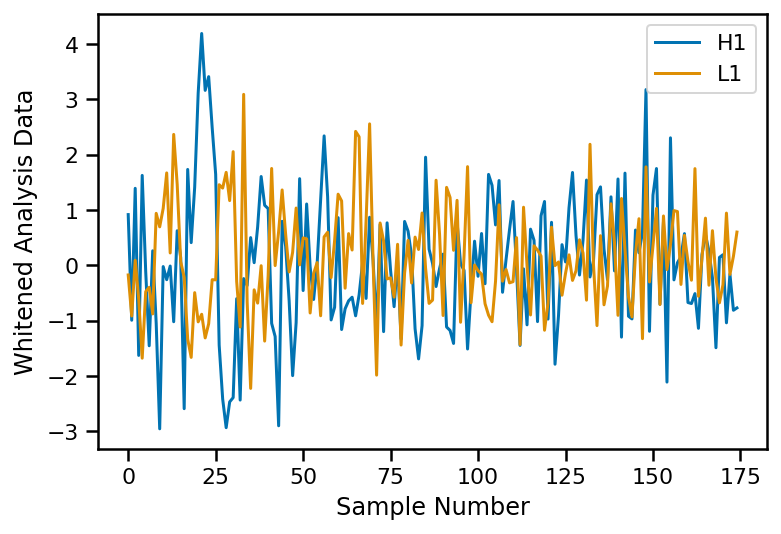

In [12]:
fit.compute_acfs()
wd = fit.whiten(fit.analysis_data)
plot(wd['H1'], label='H1')
plot(wd['L1'], label='L1')
legend(loc='best')
xlabel(r'Sample Number')
ylabel(r'Whitened Analysis Data')

Just for a sanity check, let's look at the time of arrival of the peak strain in each IFO (Isi, et al. (2019) actually gives the `H1` start time, not the geocentre time, as `1126259462.423`):

In [13]:
fit.start_times

{'H1': 1126259462.423, 'L1': 1126259462.4160156}

Here you can see that the PSD of the conditioned data only goes up to 2048 Hz (it's been downsampled to a new Nyquist frequency of 2048 Hz), and that the noise power is much smaller below 20 Hz where we have filtered it.  The vertical black line marks the frequency that corresponds to $1/T$, aka the "first Fourier" bin for our short segment.

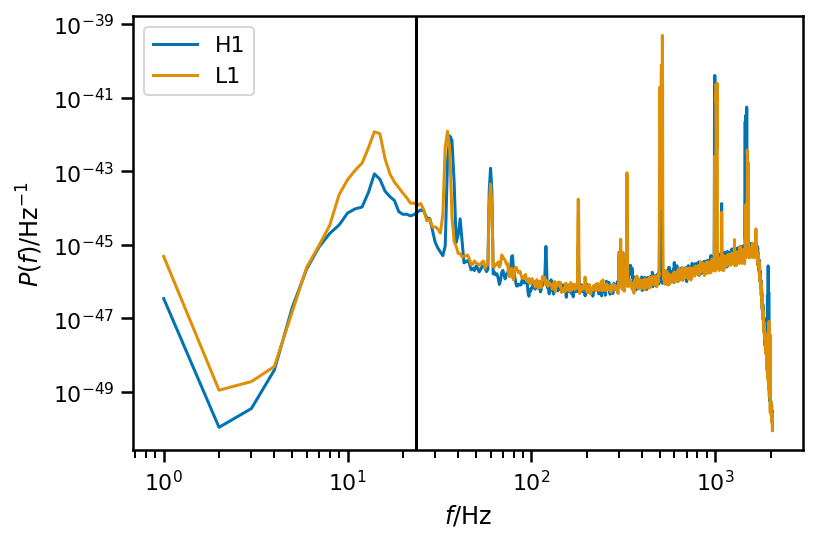

In [14]:
fit.data['H1'].get_psd(nperseg=4096).iloc[1:].plot(label='H1')
fit.data['L1'].get_psd(nperseg=4096).iloc[1:].plot(label='L1')
xscale('log')
yscale('log')
xlabel(r'$f / \mathrm{Hz}$')
ylabel(r'$P(f) / \mathrm{Hz}^{-1}$')
axvline(1/T, color='black')
legend(loc='best')

## Kerr fit

Before sampling over the posterior on modes, we need to set up some priors with reasonable choices:

In [15]:
print(fit.valid_model_options)

['A_scale', 'perturb_f', 'perturb_tau', 'df_max', 'dtau_max', 'M_min', 'M_max', 'chi_min', 'chi_max', 'flat_A_ellip']


The `flat_A_ellip` option controls whether we place a Gaussian prior on the quadratures (`flat_A_ellip = 0`, default)---which is much faster to sample because it does not have weird linear structures in the quadratures---or (as in our paper) a flat prior on `A` and `ellip` (`flat_A_ellip > 0`).  We set `A_scale = 5e-21`, which controls the scale of the Gaussian prior (`flat_A_ellip=0`) and also lets the sampler see approximately unit-scale variables (both prior choices).  

In [16]:
fit.update_prior(A_scale=5e-21, M_min=35.0, M_max=140.0)

Here are the priors (with default values for the options we didn't set).  The `perturb` are boolean arrays indicating whether to perturb `f` and `tau` around the GR values; the perturbations (if present) are bounded to a maximum amplitude.

In [17]:
fit.prior_settings

{'A_scale': 5e-21,
 'perturb_f': array([0., 0.]),
 'perturb_tau': array([0., 0.]),
 'df_max': 0.5,
 'dtau_max': 0.5,
 'M_min': 35.0,
 'M_max': 140.0,
 'chi_min': 0,
 'chi_max': 0.99,
 'flat_A_ellip': 0}

Our fit is ready to go; run it!

(The `run()` method will automatically compile the `PyStan` code the first time any fit runs in a given session, which can take a while.  Subsequent runs will use the precompiled code and be much quicker.)

In [24]:
fit.run()

Running mchi

Gradient evaluation took 0.003038 seconds
1000 transitions using 10 leapfrog steps per transition would take 30.38 seconds.
Adjust your expectations accordingly!



Gradient evaluation took 0.00295 seconds
1000 transitions using 10 leapfrog steps per transition would take 29.5 seconds.
Adjust your expectations accordingly!



Gradient evaluation took 0.00283 seconds
1000 transitions using 10 leapfrog steps per transition would take 28.3 seconds.
Adjust your expectations accordingly!



Gradient evaluation took 0.003215 seconds
1000 transitions using 10 leapfrog steps per transition would take 32.15 seconds.
Adjust your expectations accordingly!


Iteration:    1 / 2000 [  0%]  (Warmup)
Iteration:    1 / 2000 [  0%]  (Warmup)
Iteration:    1 / 2000 [  0%]  (Warmup)
Iteration:    1 / 2000 [  0%]  (Warmup)
Iteration:  200 / 2000 [ 10%]  (Warmup)
Iteration:  200 / 2000 [ 10%]  (Warmup)
Iteration:  200 / 2000 [ 10%]  (Warmup)
Iteration:  400 / 2000 [ 20%]  (Warmup)
Iteration: 

To run all diagnostics call pystan.check_hmc_diagnostics(fit)


Iteration: 2000 / 2000 [100%]  (Sampling)

 Elapsed Time: 104.131 seconds (Warm-up)
               72.3245 seconds (Sampling)
               176.456 seconds (Total)



`fit.result` contains an arviz object giving our results:

In [25]:
az.summary(fit.result, var_names=['A', 'M', 'chi', 'f', 'tau'])

mean      sd   hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
A[0]      0.000   0.000    0.000    0.000      0.000    0.000    2288.0   
A[1]      0.000   0.000    0.000    0.000      0.000    0.000    2241.0   
M        69.857   9.173   53.623   85.786      0.264    0.187    1159.0   
chi       0.596   0.219    0.156    0.920      0.007    0.005     918.0   
f[0]    237.158  12.179  214.598  259.832      0.344    0.243    1328.0   
f[1]    230.428  14.226  203.384  256.047      0.434    0.307    1113.0   
tau[0]    0.004   0.001    0.003    0.006      0.000    0.000    1082.0   
tau[1]    0.001   0.000    0.001    0.002      0.000    0.000    1073.0   

        ess_tail  r_hat  
A[0]      2590.0    1.0  
A[1]      2487.0    1.0  
M         1132.0    1.0  
chi        666.0    1.0  
f[0]      1477.0    1.0  
f[1]      1390.0    1.0  
tau[0]    1087.0    1.0  
tau[1]    1070.0    1.0

We can plot a trace, and see visually that the sampling seems OK:

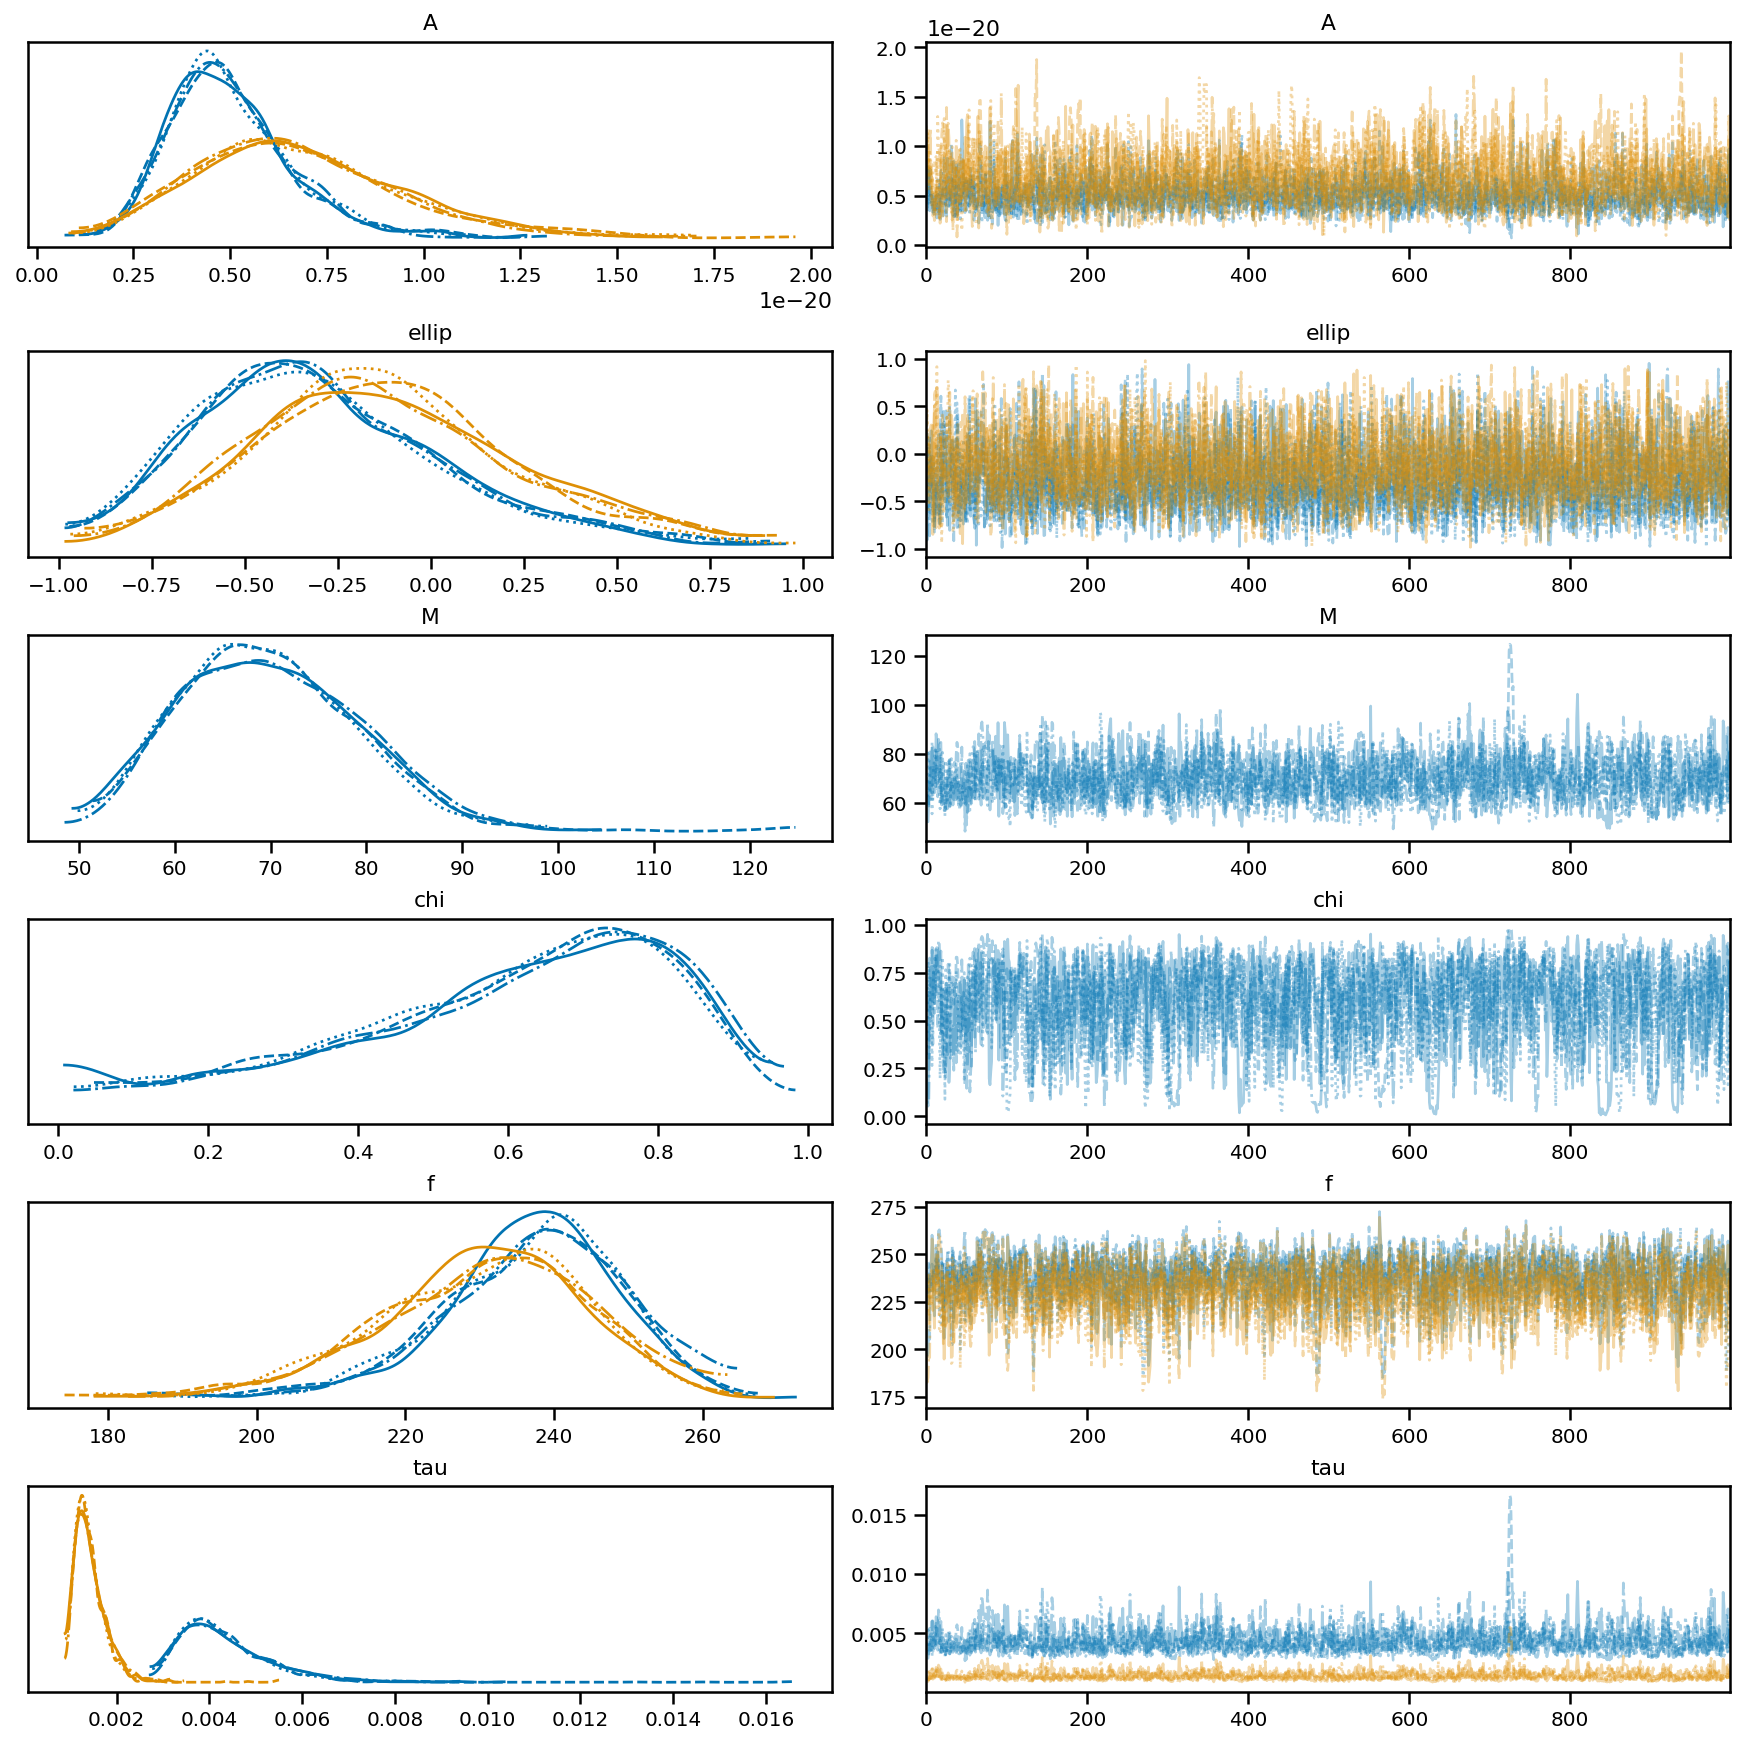

In [26]:
az.plot_trace(fit.result, var_names=['A', 'ellip', 'M', 'chi', 'f', 'tau'], compact=True);

The total mass and spin that we recover are reasonable given the full waveform analysis of GW150914 (remember that the total mass will be the *detector frame* total mass!).  Note the use of `ringdown.kdeplot_2d_clevels` which draws contours at credible levels of the KDE estimate of the posterior distribution (the default, used here, is to draw contours at the 0.1, ..., 0.9 credible levels).

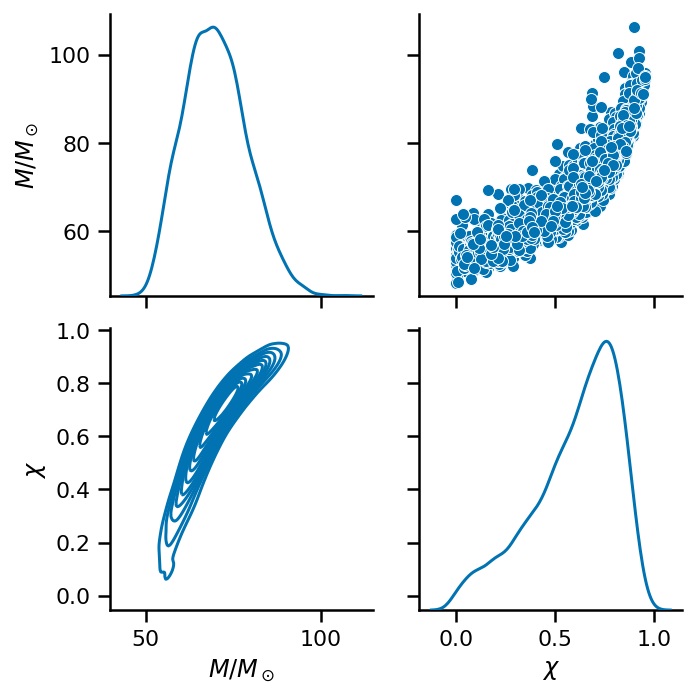

In [20]:
pg = sns.PairGrid(pd.DataFrame({r'$M / M_\odot$': fit.result.posterior.M.values.flatten(),
                                r'$\chi$': fit.result.posterior.chi.values.flatten()}),
                  diag_sharey=False)
pg.map_diag(sns.kdeplot)
pg.map_upper(sns.scatterplot)
pg.map_lower(gwtones.kdeplot_2d_clevels)

The fundamental mode is about $240 \, \mathrm{Hz}$; we measure its frequency to ~5%.

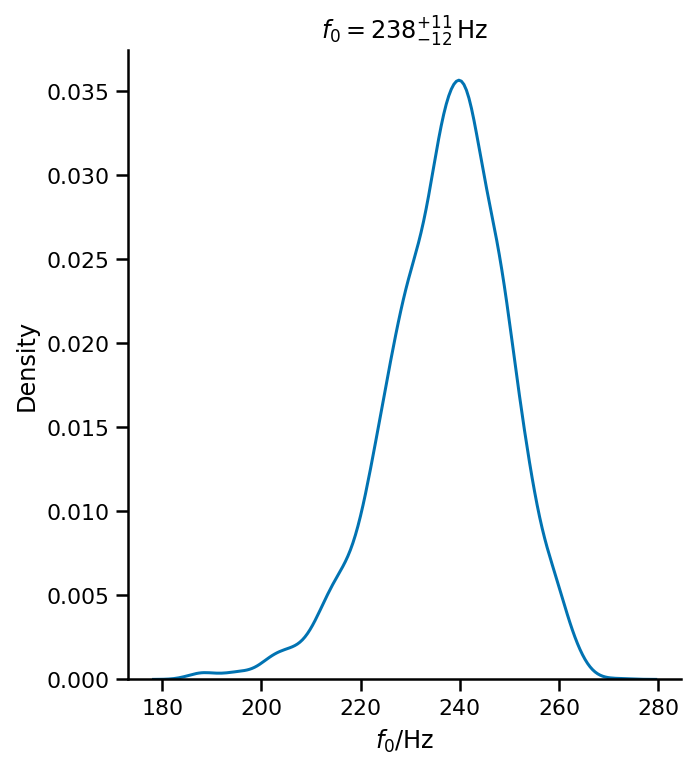

In [27]:
f0 = fit.result.posterior.f.values[:,:,0].flatten()
m = median(f0)
h = quantile(f0, 0.84)
l = quantile(f0, 0.16)
sns.displot(fit.result.posterior.f.values[:,:,0].flatten(), kind='kde')
xlabel(r'$f_0 / \mathrm{Hz}$');
title(r'$f_0 = {:.0f}^{{+{:.0f}}}_{{-{:.0f}}} \, \mathrm{{Hz}}$'.format(m, h-m, m-l));

Because of the Gaussian prior we have placed on the mode quadratures, the prior on the mode amplitudes is not flat (for small amplitude it goes as $A^3$ and then decays like a Gaussian at large amplitudes).  This is evident in the plot below.

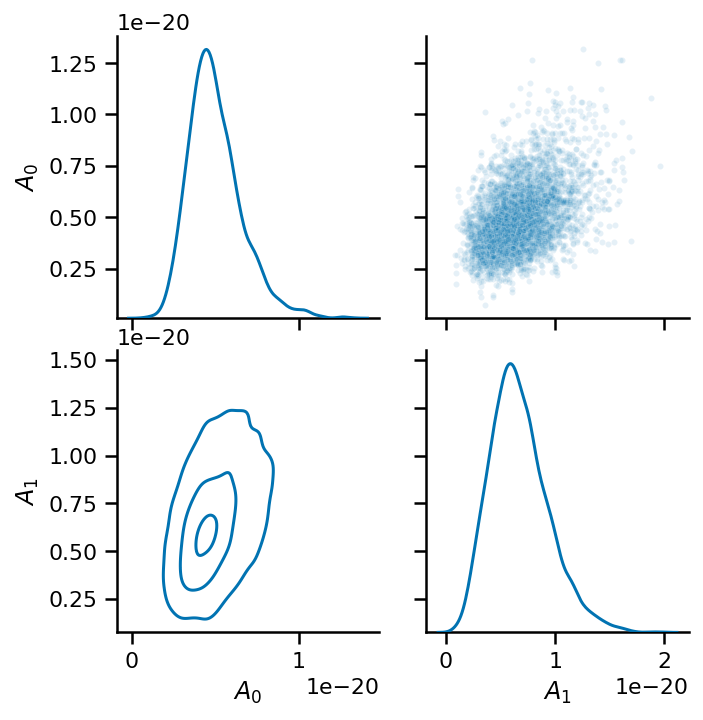

In [28]:
pg = sns.PairGrid(pd.DataFrame({r'$A_0$': fit.result.posterior.A.values[:,:,0].flatten(),
                                r'$A_1$': fit.result.posterior.A.values[:,:,1].flatten()}),
                  diag_sharey=False)
pg.map_diag(sns.kdeplot)
pg.map_upper(sns.scatterplot, alpha=0.1, marker='.')
pg.map_lower(gwtones.kdeplot_2d_clevels, levels=[0.9, 0.5, 0.1])

Get mean signal reconstructions at each detector:

In [29]:
# mean reconstructed signal at each detector
ms = {ifo: fit.result.posterior.h_det.mean(axis=(0,1)).values[i,:] 
      for i, ifo in enumerate(fit.ifos)} 

# mean reconstructed fundamental mode at each detector
mf = {ifo: fit.result.posterior.h_det_mode.mean(axis=(0,1)).values[i,0,:] 
      for i, ifo in enumerate(fit.ifos)} 

# mean reconstructed overtone at each detector
mo = {ifo: fit.result.posterior.h_det_mode.mean(axis=(0,1)).values[i,1,:] 
      for i, ifo in enumerate(fit.ifos)} 

Whiten the reconstructions; the `fit.whiten` accepts a dict mapping detector names to time series, and returns a dict of whitened time series:

In [30]:
wd = fit.whiten(fit.analysis_data)
ws = fit.whiten(ms)
wf = fit.whiten(mf)
wo = fit.whiten(mo)

Compute SNRs:

In [31]:
snr_of_mean_waveform = sqrt(sum([np.dot(wd[d], ws[d])**2 / np.dot(ws[d], ws[d]) for d in fit.ifos]))
print('SNR of ringdown = {:.1f}'.format(snr_of_mean_waveform))

SNR of ringdown = 11.4


Here is a plot of the un-whitened (i.e. raw) ringdown signal, also decomposed into modes.

In [32]:
ts = [d.time for d in fit.analysis_data.values()]

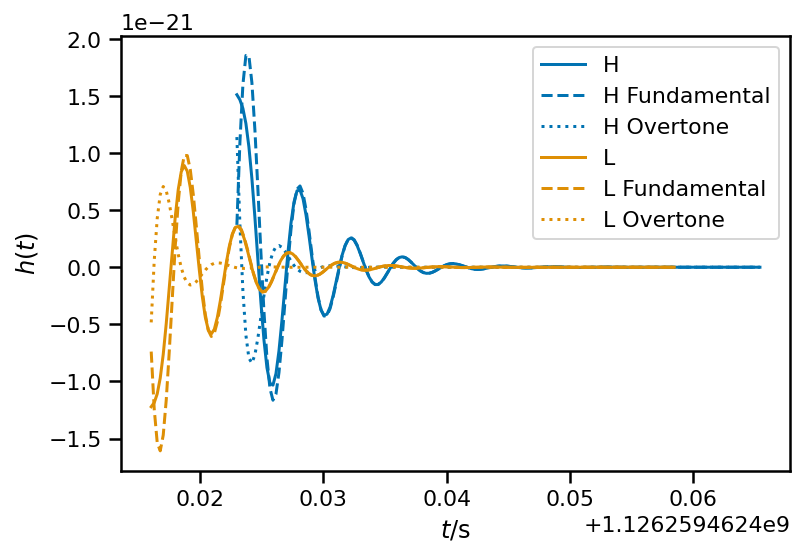

In [33]:
for ifo in fit.ifos:
    t = fit.analysis_data[ifo].time
    l, = plot(t, ms[ifo], label=ifo[0])
    plot(t, mf[ifo], ls='--', color=l.get_color(), label=ifo[0]+' Fundamental')
    plot(t, mo[ifo], ls=':', color=l.get_color(), label=ifo[0]+' Overtone')

legend(loc='best');
xlabel(r'$t/\mathrm{s}$');
ylabel(r'$h(t)$');

And here are plots of the whitened signal compared to the whitened data; these can be used to visually assess the fit.

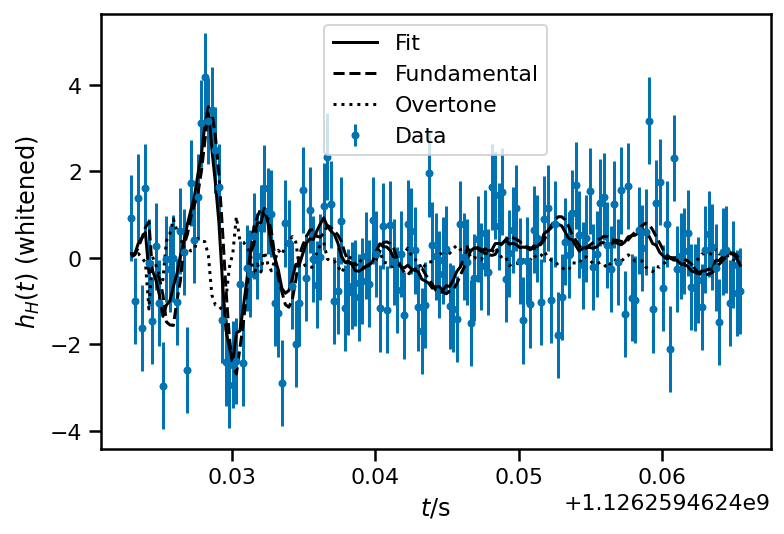

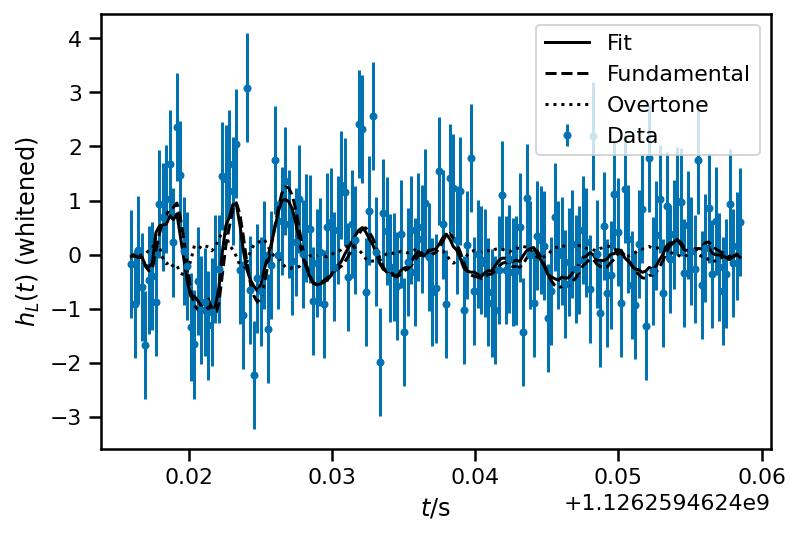

<Figure size 432x288 with 0 Axes>

In [34]:
for ifo in fit.ifos:
    t = fit.analysis_data[ifo].time
    errorbar(t, wd[ifo], yerr=ones_like(wd[ifo]), fmt='.', label='Data')
    plot(t, ws[ifo], color="black", label='Fit')
    plot(t, wf[ifo], color="black", ls='--', label='Fundamental')
    plot(t, wo[ifo], color='black', ls=':', label='Overtone')

    xlabel(r'$t / \mathrm{s}$')
    ylabel(r'$h_%s(t)$ (whitened)' % ifo[0])
    legend(loc='best')
    figure()

If you are ever confused about the prior choices *the same fit object* can be used to sample from the prior.  (Note: the `flat_A_ellip` prior is *improper*, with no bound on the amplitude, so sampling the prior will fail if you use this option; the posterior is proper, however, since the high-amplitude parameter space is ruled out by the likelihood.)

In [35]:
fit.run(prior=True)

Running mchi

Gradient evaluation took 0.001227 seconds
1000 transitions using 10 leapfrog steps per transition would take 12.27 seconds.
Adjust your expectations accordingly!


Iteration:    1 / 2000 [  0%]  (Warmup)

Gradient evaluation took 0.000784 seconds
1000 transitions using 10 leapfrog steps per transition would take 7.84 seconds.
Adjust your expectations accordingly!


Iteration:    1 / 2000 [  0%]  (Warmup)

Gradient evaluation took 0.000663 seconds
1000 transitions using 10 leapfrog steps per transition would take 6.63 seconds.
Adjust your expectations accordingly!


Iteration:    1 / 2000 [  0%]  (Warmup)

Gradient evaluation took 0.000684 seconds
1000 transitions using 10 leapfrog steps per transition would take 6.84 seconds.
Adjust your expectations accordingly!


Iteration:    1 / 2000 [  0%]  (Warmup)
Iteration:  200 / 2000 [ 10%]  (Warmup)
Iteration:  200 / 2000 [ 10%]  (Warmup)
Iteration:  200 / 2000 [ 10%]  (Warmup)
Iteration:  200 / 2000 [ 10%]  (Warmup)
Iteration:

To run all diagnostics call pystan.check_hmc_diagnostics(fit)


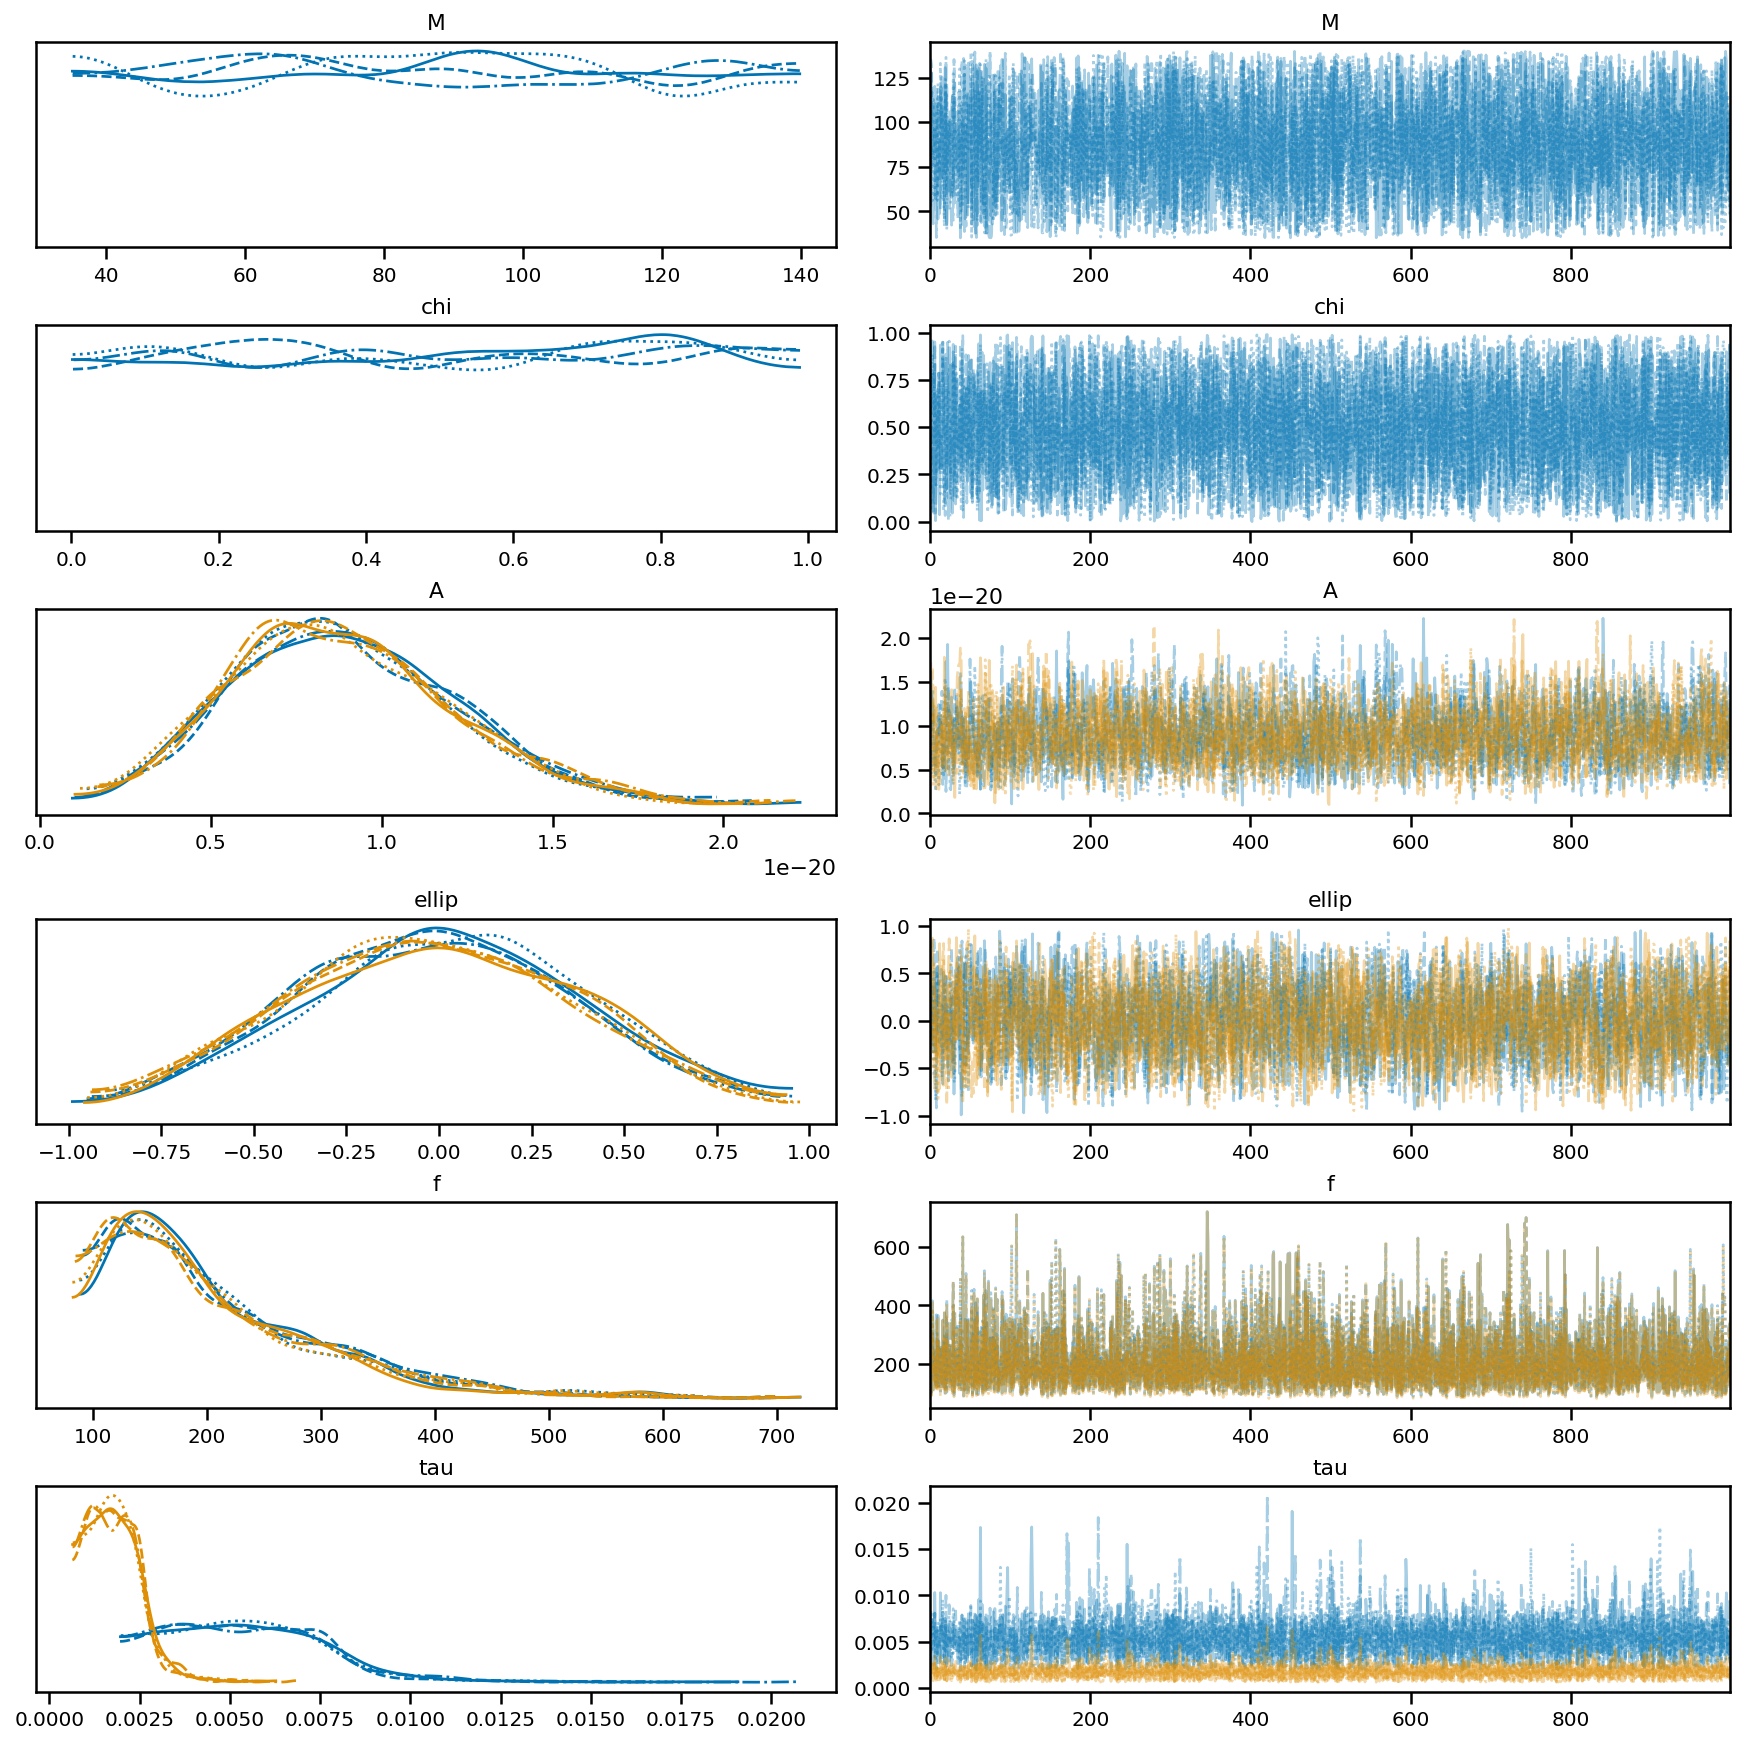

In [36]:
az.plot_trace(fit.prior, var_names=['M', 'chi', 'A', 'ellip', 'f', 'tau']);

## Beyond-Kerr fit

We can allow for perturbations to the frequency and damping rates of subsets of the ringdown modes as a spectroscopic test of GR.  First, we copy the fit object so that we are sure to use the same data, prior settings, etc, in the GR test as we did above:

In [19]:
fit_testgr = copy.copy(fit)

A reminder about the prior options we can set:

In [20]:
print(fit_testgr.valid_model_options)

['A_scale', 'perturb_f', 'perturb_tau', 'df_max', 'dtau_max', 'M_min', 'M_max', 'chi_min', 'chi_max', 'flat_A_ellip']


To test GR, we allow for perturbations of the overtone frequency and damping time.  The parameterization used here introduces $\delta f$ and $\delta \tau$ parameters and defines 
$$
f = f_{\mathrm{GR}} e^{\delta f}
$$
and
$$
\tau = \tau_{\mathrm{GR}} e^{\delta \tau}.
$$
Thus the perturbation is defined for all values $-\infty < \delta f, \delta \tau < \infty$ and for small values of the perturbation parameter is is the *relative* deviation of the frequency/damping time from the GR value.  By default we truncate $-1/2 < \delta f, \delta \tau < 1/2$ (corresponding to a factor of $\sqrt{e} \simeq 1.6$ change away from the GR value), but this can be changed in the prior settings as well.

In [21]:
fit_testgr.update_prior(perturb_f=[0,1], perturb_tau=[0,1])
fit_testgr.prior_settings

{'A_scale': 5e-21,
 'perturb_f': [0, 1],
 'perturb_tau': [0, 1],
 'df_max': 0.5,
 'dtau_max': 0.5,
 'M_min': 35.0,
 'M_max': 140.0,
 'chi_min': 0,
 'chi_max': 0.99,
 'flat_A_ellip': 0}

In [22]:
fit_testgr.run()

Running mchi

Gradient evaluation took 0.003058 seconds
1000 transitions using 10 leapfrog steps per transition would take 30.58 seconds.
Adjust your expectations accordingly!



Gradient evaluation took 0.002807 seconds
1000 transitions using 10 leapfrog steps per transition would take 28.07 seconds.
Adjust your expectations accordingly!



Gradient evaluation took 0.003251 seconds
1000 transitions using 10 leapfrog steps per transition would take 32.51 seconds.
Adjust your expectations accordingly!



Gradient evaluation took 0.002874 seconds
1000 transitions using 10 leapfrog steps per transition would take 28.74 seconds.
Adjust your expectations accordingly!


Iteration:    1 / 2000 [  0%]  (Warmup)
Iteration:    1 / 2000 [  0%]  (Warmup)
Iteration:    1 / 2000 [  0%]  (Warmup)
Iteration:    1 / 2000 [  0%]  (Warmup)
Iteration:  200 / 2000 [ 10%]  (Warmup)
Iteration:  200 / 2000 [ 10%]  (Warmup)
Iteration:  200 / 2000 [ 10%]  (Warmup)
Iteration:  200 / 2000 [ 10%]  (Warmup)
Iterati

To run all diagnostics call pystan.check_hmc_diagnostics(fit)


Iteration: 2000 / 2000 [100%]  (Sampling)

 Elapsed Time: 155.392 seconds (Warm-up)
               73.133 seconds (Sampling)
               228.525 seconds (Total)



The fit looks a bit more wonky (if this were for publication purposes, we would probably want to figure out why the one chain is getting "stuck;" probably running for a while longer during warmup would help it adapt better and get "out" of its position), but it's good enough for our purposes here.

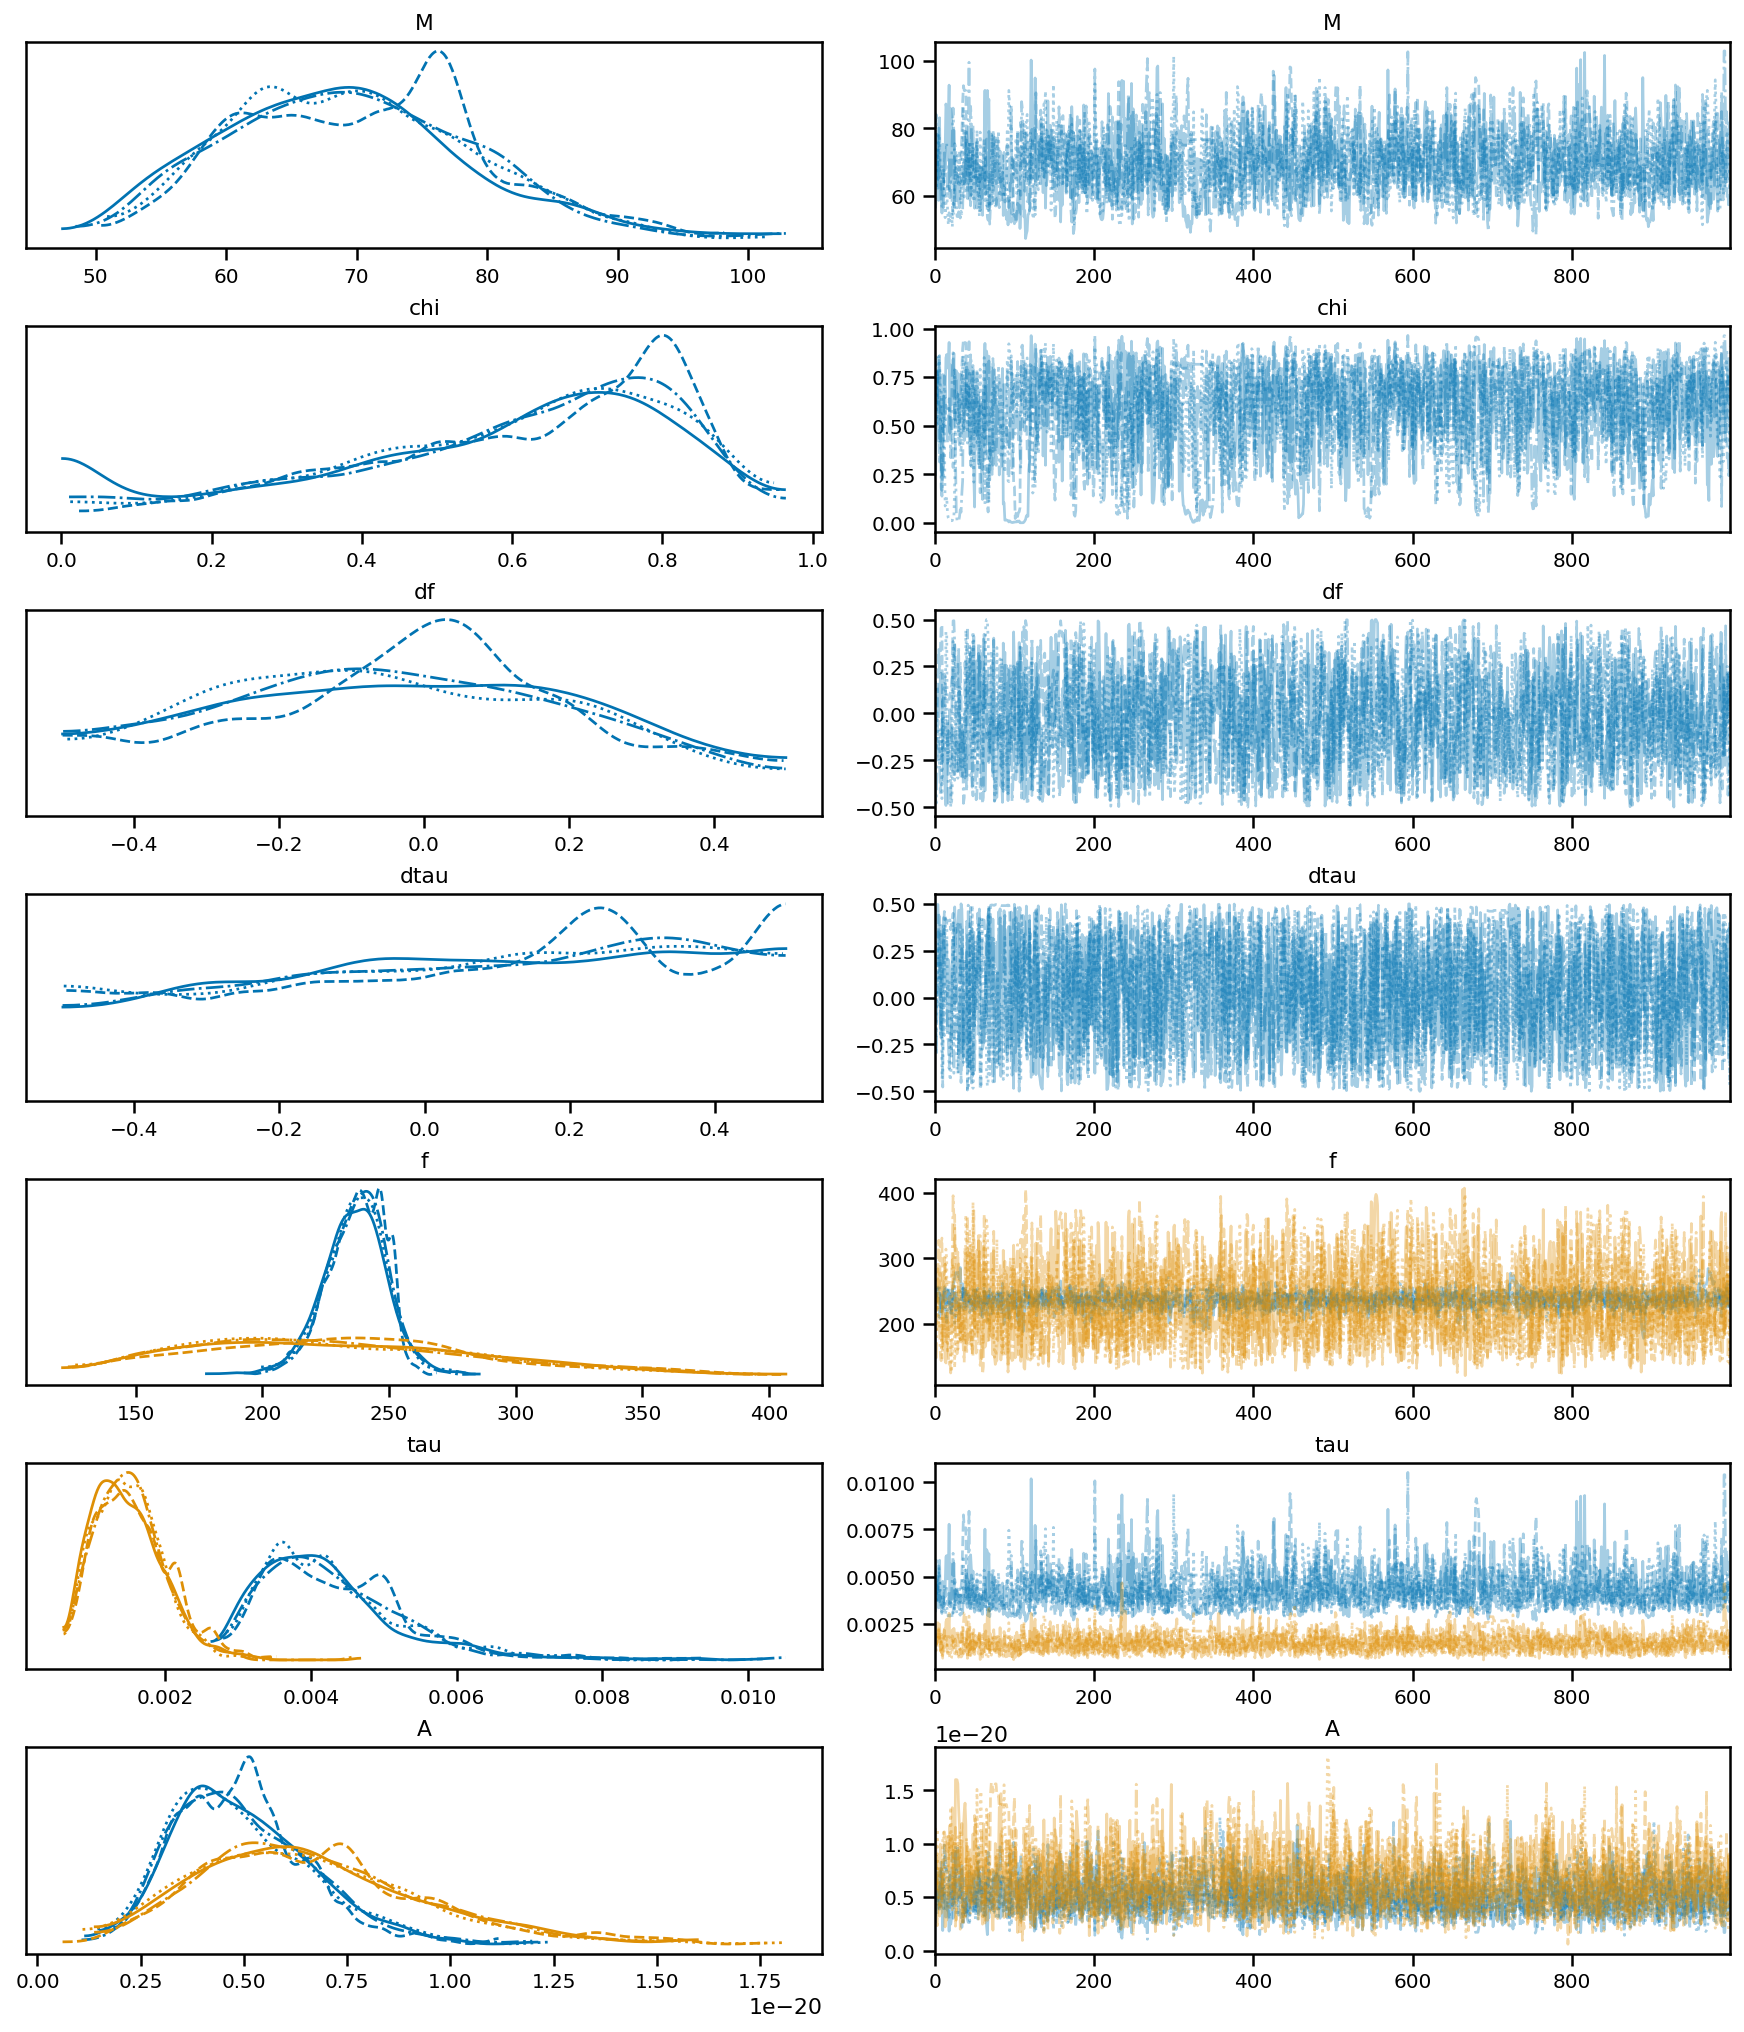

In [23]:
az.plot_trace(fit_testgr.result, var_names=['M', 'chi', 'df', 'dtau', 'f', 'tau', 'A'],
              coords={'df_dim_0': 1, 'dtau_dim_0': 1});

You can see that we place a constraint on the $\delta f$ parameter; the 1-sigma range is about 25\%, and the posterior peaks noticeably around the GR value of $\delta f = 0$.  The posterior on $\delta \tau$ is nearly flat, with a modest preference for larger $\delta \tau$, but still fully consistent with GR.  In 2D (lower left plot) the GR value of $(0,0)$ is contained within the 50% credible contour.

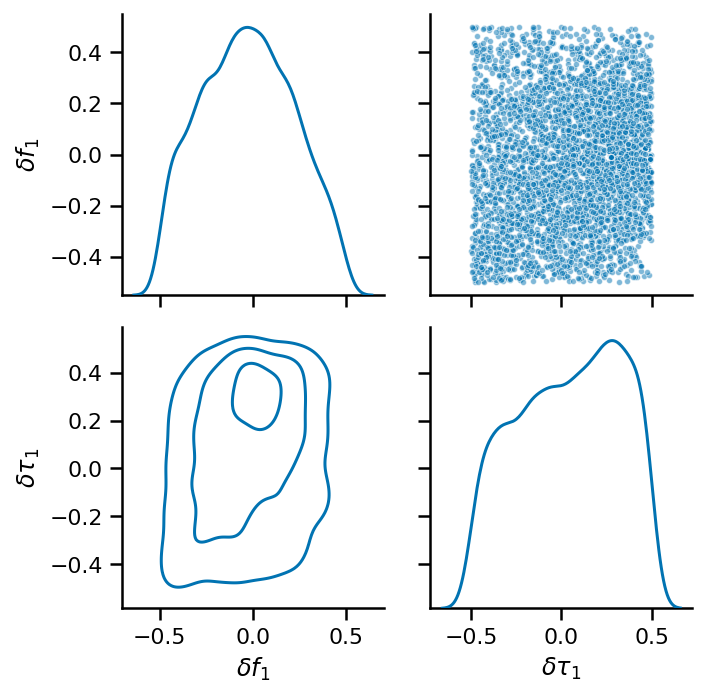

In [24]:
pg = sns.PairGrid(pd.DataFrame({r'$\delta f_1$': fit_testgr.result.posterior.df.values[:,:,1].flatten(),
                                r'$\delta \tau_1$': fit_testgr.result.posterior.dtau.values[:,:,1].flatten()}),
                  diag_sharey=False)
pg.map_upper(sns.scatterplot, marker='.', alpha=0.5)
pg.map_diag(sns.kdeplot)
pg.map_lower(gwtones.kdeplot_2d_clevels, levels=[0.9, 0.5, 0.1])

In [25]:
df = fit_testgr.result.posterior.df.values[:,:,1].flatten()
print('1-sigma (68%) range of df in [{:.2f}, {:.2f}]'.format(quantile(df, 0.16), quantile(df, 0.84)))

1-sigma (68%) range of df in [-0.30, 0.24]
